In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

In [17]:
filename = '../002Data/clean data.csv'
data = pd.read_csv(filename)
# 查看基本信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   标题          680 non-null    object 
 1   地区          680 non-null    object 
 2   位置          680 non-null    object 
 3   类型          680 non-null    object 
 4   均价/平方米每元    680 non-null    int64  
 5   室厅数         680 non-null    object 
 6   面积          680 non-null    float64
 7   标签          680 non-null    object 
 8   总价          680 non-null    float64
 9   对数均价/平方米每元  680 non-null    float64
 10  对数总价        680 non-null    float64
 11  对数面积        680 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 63.9+ KB


In [18]:
data.describe()

,均价/平方米每元,面积,总价,对数均价/平方米每元,对数总价,对数面积
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,23241.694118,137.488971,364.707059,9.866799,5.425729,4.729791
std,14229.982383,197.475765,603.589481,0.624557,0.881648,0.485620
min,4000.000000,28.000000,15.300000,8.294050,2.727853,3.332205
25%,12000.000000,95.500000,125.000000,9.392662,4.828314,4.559126
50%,20000.000000,108.000000,201.500000,9.903488,5.305762,4.682131
75%,30000.000000,128.000000,400.000000,10.308953,5.991465,4.852030
max,66000.000000,3241.500000,7804.800000,11.097410,8.962494,8.083791


In [19]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="../003Attachments/SIMHEI.TTF", size=14) 
# 需根据实际字体路径调整，这里以Windows系统下黑体路径为例
plt.rcParams['font.family'] = font.get_name()

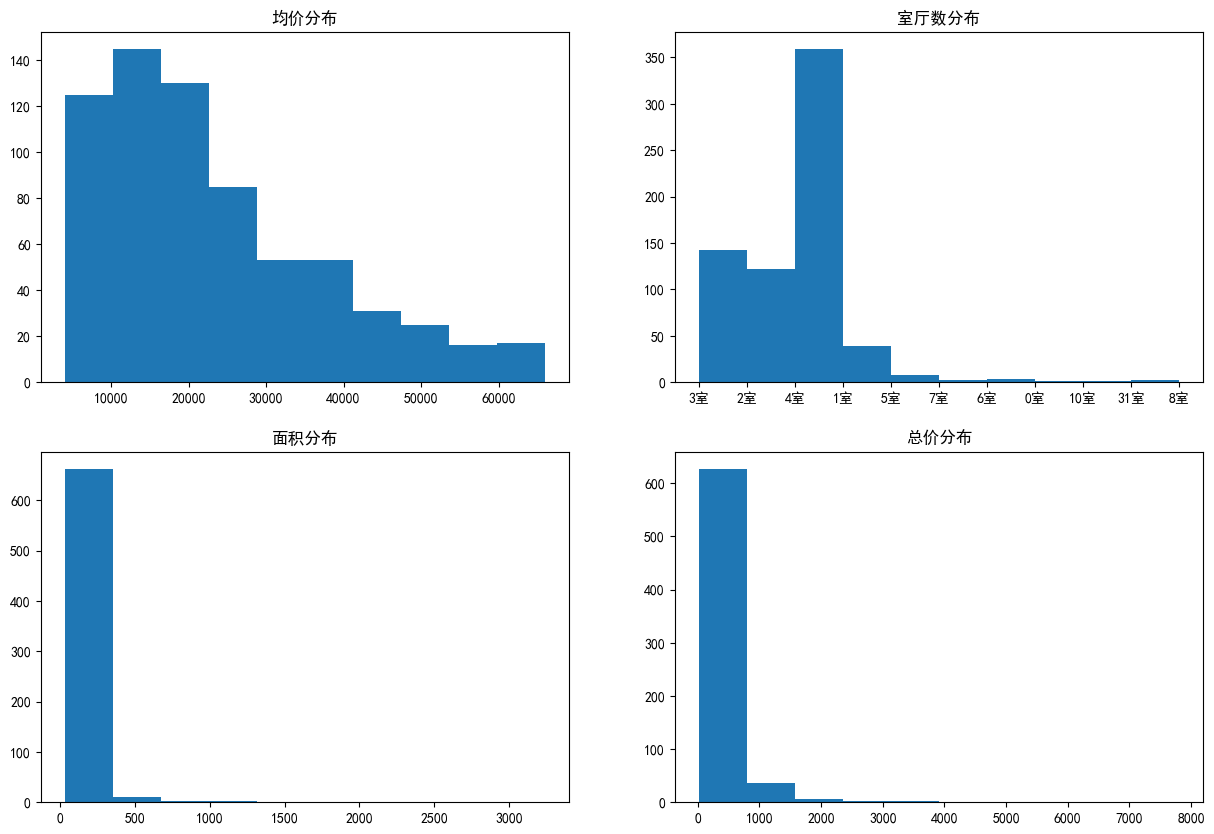

In [20]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.hist(data['均价/平方米每元'])
plt.title('均价分布')

plt.subplot(2,2,2)
plt.hist(data['室厅数'])
plt.title('室厅数分布')

plt.subplot(2,2,3)
plt.hist(data['面积'])
plt.title('面积分布')

plt.subplot(2,2,4)
plt.hist(data['总价'])
plt.title('总价分布')

plt.show()

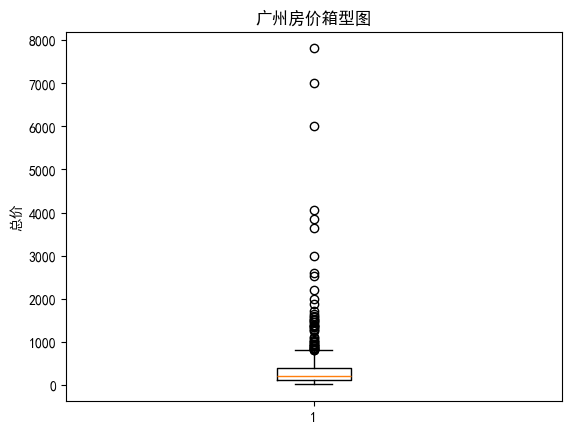

In [25]:
prices=data['总价']

plt.boxplot(prices)
plt.title('广州房价箱型图')
plt.ylabel('总价')
plt.show()

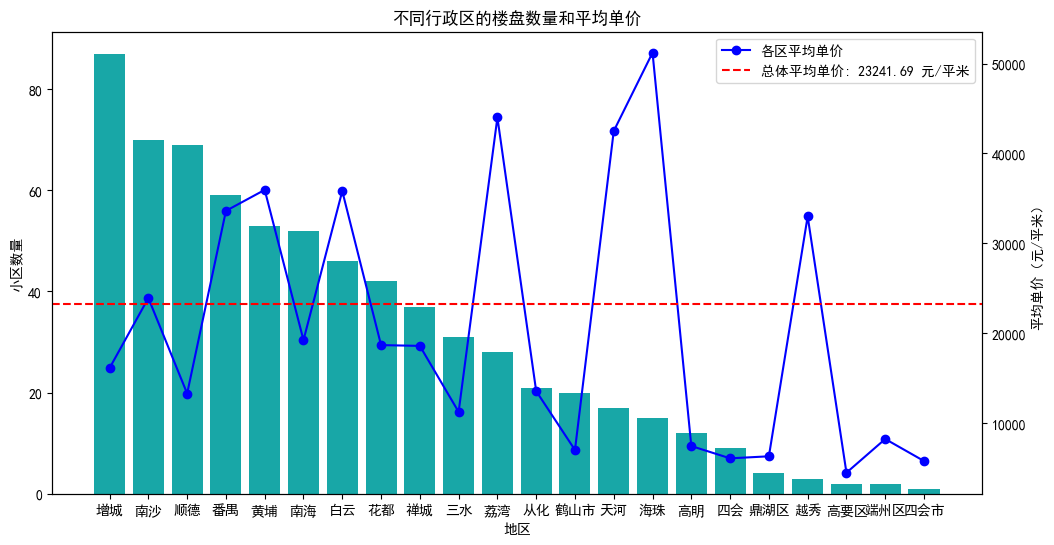

In [22]:
# 计算各地区的小区数量，并按降序排列
region_order = data['地区'].value_counts().index
# print(region_order)

# 计算各行政区的平均单价，按新的顺序对平均单价排序
average_price1 = data.groupby('地区')['均价/平方米每元'].mean()
average_price1 = average_price1.reindex(region_order)
# print(average_price1)

# 计算总体平均单价
overall_average_price = data['均价/平方米每元'].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

# 按降序排列绘制小区数量的柱状图
sns.countplot(data=data, x='地区', order=region_order, ax=ax1, color='c')
ax1.set_xlabel('地区')
ax1.set_ylabel('小区数量')
ax1.tick_params(axis='x')

# 创建第二个坐标轴，用于绘制各个行政区的单价折线图
ax2 = ax1.twinx()
ax2.plot(average_price1.index, average_price1.values, color='b', marker='o', linestyle='-',label='各区平均单价')
ax2.set_ylabel('平均单价（元/平米）')

# 标出总体平均单价
ax2.axhline(overall_average_price, color='r', linestyle='--', label=f'总体平均单价: {overall_average_price:.2f} 元/平米')
ax2.legend(loc='upper right')

plt.title('不同行政区的楼盘数量和平均单价')
plt.show()

Counter({'人车分流': 466, '车位充足': 310, '品牌房企': 267, '绿化率高': 265, '低总价': 244, '国央企': 227, '佛山楼盘': 201, '低单价': 188, '大型社区': 91, '小型社区': 53, '封闭管理': 52, '近地铁': 45, '楼盘': 38, '地铁沿线': 37, '公交直达': 33, '低密居所': 27, '置换改善': 22, '入户花园': 21, '贴心物业': 20, '健身跑道': 18, '特价好房': 17, '自持商业': 11, '养老舒适': 9, '儿童乐园': 8, '休闲会所': 7, '多轨交汇': 6, '水系园林': 4, '高品质小区': 4, '绿色建筑': 3, '大平层': 3, '优惠楼盘': 3, '科技住宅': 3, '现房': 2, '大两居': 2, '小三居': 2, '避暑': 1, '临近高速': 1, '大三居': 1, '私属庭院': 1, 'loft': 1, '动静分明': 1, '小户型': 1, '旅游地产': 1, '实体样板间': 1, '已交房超2年': 1, '已交房1年内': 1})


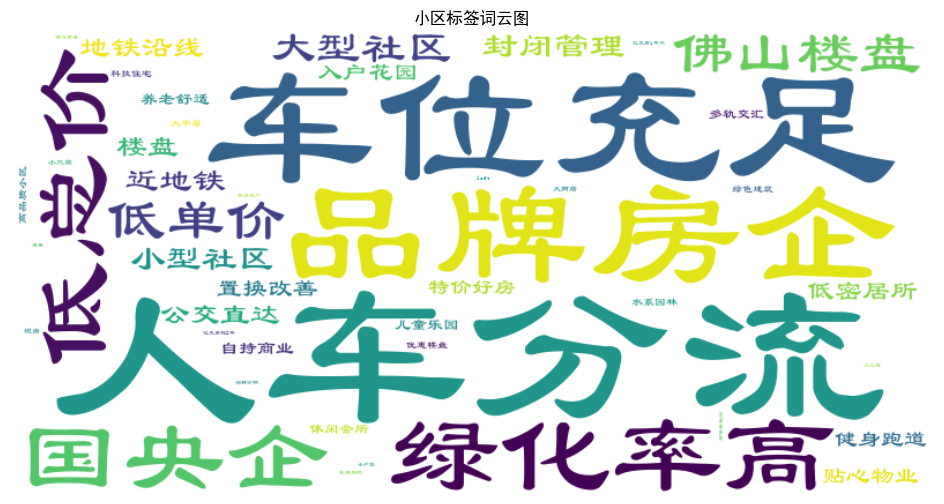

In [23]:
# 提取小区标签并统计出现次数
tags = data['标签'].str.split(',').explode().str.strip()
tag_counts = Counter(tags)
print(tag_counts)

# 生成词云图,在本地运行时候font_path替换成本地字体
wordcloud = WordCloud(font_path='../003Attachments/SIMLI.TTF',background_color='white', width=800, height=400).generate_from_frequencies(tag_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('小区标签词云图')
plt.show()

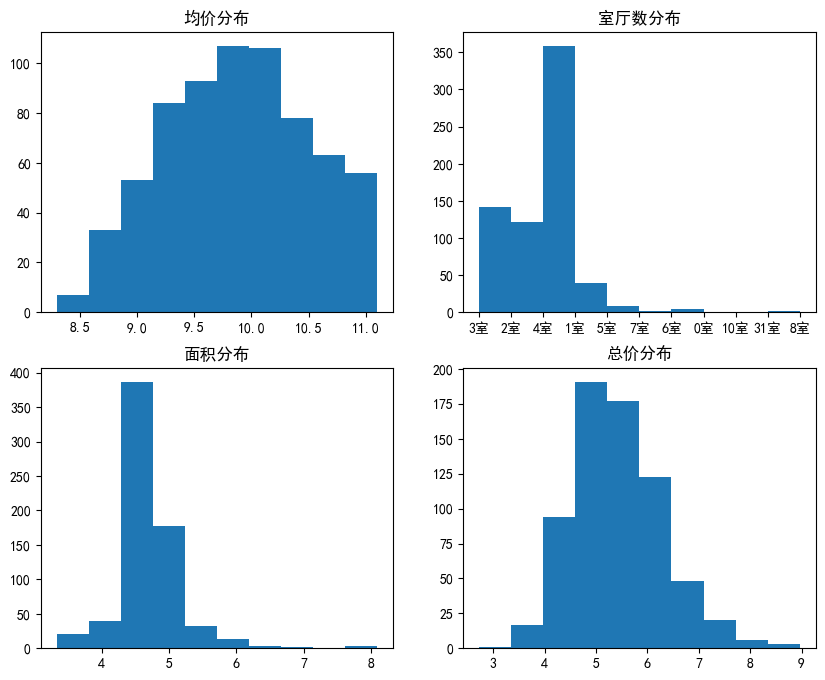

In [24]:
# 通过以上的描述分析可知【均价，总价，面积】呈现偏态分布
# 进行对数变换
data['对数均价/平方米每元'] = np.log(data['均价/平方米每元'])
data['对数总价'] = np.log(data['总价'])
data['对数面积'] = np.log(data['面积'])

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.hist(data['对数均价/平方米每元'])
plt.title('均价分布')

plt.subplot(2,2,2)
plt.hist(data['室厅数'])
plt.title('室厅数分布')

plt.subplot(2,2,3)
plt.hist(data['对数面积'])
plt.title('面积分布')

plt.subplot(2,2,4)
plt.hist(data['对数总价'])
plt.title('总价分布')

plt.show()